# Submission

- ensembel CE models (last fc layer) 
 1. street view 
 2. top view

In [2]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console

In [3]:
#--- all infos
inference_dict ={
    'models':[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_5.yaml', 'finetune_8.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('./configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    inference_dict['cfgs'].append(cfg)
    print("Model run version : ", cfg.RUN_VERSION)

Model run version :  15
Model run version :  18


In [4]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [5]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [6]:
ckpt_paths = [
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/15_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.65_epoch_8.pth",
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/18_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.7226_epoch_5.pth" ]

for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i]))

In [52]:
import torch.nn as nn 

class EnsembleModel(nn.Module):

    '''
    - two models will be ensembled
    - super 상속 시키지 않으면 nn.module 로 인식안되서 forward 시에 input 복수로 줄 수 없음 주의할 것 
    '''

    def __init__(self, modelA, modelB):
        super(EnsembleModel,self).__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.classifier = nn.Linear(7 * 2, 7)
        
    # def forward(self, *inputs):
    #     for module in self._modules.values():
    #         if type(inputs) == tuple:
    #             inputs = module(*inputs)
    #         else:
    #             inputs = module(inputs)
    #     return inputs
        
    def forward(self, x1,x2):
        
        #x1,x2 = inputs[0], inputs[1]
        x1 = self.modelA(x1)
        x2 = self.modelB(x2)
        out = torch.cat( (x1, x2), dim=1)
        out = self.classifier(out)
        return out

#--
ensemble_model = EnsembleModel(inference_dict['models'][0], inference_dict['models'][1])
    

In [53]:
ckpt_path_ = "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/Ensemble_Model_15_18_f1_0.7344_epoch_14.pth"
ensemble_model.load_state_dict(torch.load(ckpt_path_))

<All keys matched successfully>

In [54]:
train_set = map_dataset.Map_Dataset_v7(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid") 
valid_set = map_dataset.Map_Dataset_v7(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

testloader = DataLoader(valid_set, 1, num_workers=cfg.NUM_WORKERS, pin_memory=True) 


idx :  101
torch.Size([1, 3, 448, 448])
torch.Size([1, 3, 448, 448])
2 < Label > 
2 < Ensemble Model Prediction > 
tensor([[1.0708e-05, 1.5039e-04, 9.9770e-01, 1.9878e-03, 2.5888e-05, 2.7195e-05,
         9.7116e-05]], device='cuda:3')


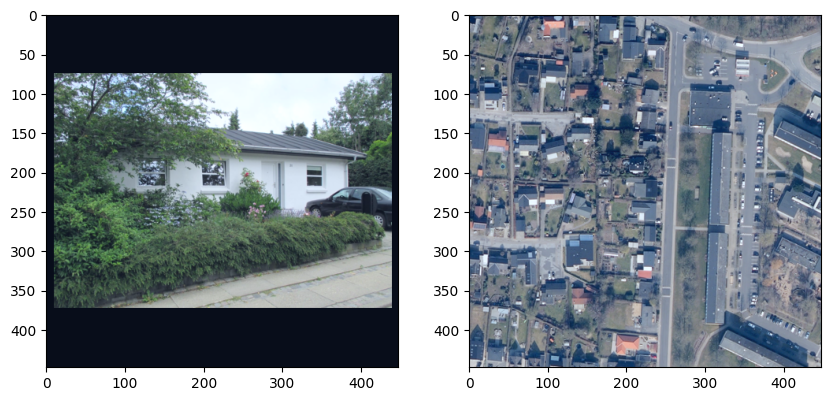

In [65]:
#--- inference
device = "cuda:3"
cfg.DEVICE = device
#--- 

idx_ = random.randint(0,999)
print("idx : ", idx_)

dataset = valid_set

street_view = dataset.__getitem__(idx_)[0]
top_view = dataset.__getitem__(idx_)[1]
img_torch_1 = street_view 
img_torch_2 = top_view


def infer_ensemble_model(img_torch_1, img_torch_2,model,loss_type):
    
    with torch.no_grad():
        img_torch_1 = img_torch_1.to(device)
        img_torch_2 = img_torch_2.to(device)
        
        model = model.eval()
        model = model.to(device)
        
        img_torch_1 = img_torch_1.unsqueeze(0)
        img_torch_2 = img_torch_2.unsqueeze(0)
        
        print(img_torch_1.shape)
        print(img_torch_2.shape)
        
        preds = model(img_torch_1,img_torch_2)
        
        if loss_type == "CE":
            preds_ = preds.softmax(-1).argmax(-1)
        elif loss_type == "MSE" or loss_type == "MAE":
            preds_ = preds
        print(dataset.__getitem__(idx_)[-1], "< Label > ")
        print(preds_.item(), f"< Ensemble Model Prediction > ")
        #print(preds)
        print(preds.softmax(-1))
        
        img_torch_1 = img_torch_1.squeeze(0)
        img1 = img_torch_1.clone() 
        
        img_torch_2 = img_torch_2.squeeze(0)
        img2 = img_torch_2.clone()
        
        # denormal
        img1 = ((img1) * 0.22) + 0.5
        img2 = ((img2) * 0.22) + 0.5
        # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        #---
                
        img1 = img1.permute(1,2,0).cpu()
        img1 = np.asarray(img1)
        img2 = img2.permute(1,2,0).cpu()
        img2 = np.asarray(img2)
        
        #---
        fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,10))
        ax[0].imshow(img1)
        ax[1].imshow(img2)
        
        #plt.imshow(img1)
        
            
#-- 
infer_ensemble_model(img_torch_1,img_torch_2,model,"CE")

# Test

In [98]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_test = os.listdir(test_path)
names_test = sorted(names_test)

In [99]:
submit_df = pd.DataFrame(
    {"idx":[i for i in range(len(names_test))],
     "names_test":names_test,
     "street_veiw_exists":[False for i in range(len(names_test))],
     "street_view_prediction" :[-1 for i in range(len(names_test))],
     "top_view_prediction" : [-1 for i in range(len(names_test))]}
)

In [100]:
submit_df.head()

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,False,-1,-1
1,1,22pujdqtiu,False,-1,-1
2,2,23ykackznc,False,-1,-1
3,3,2435ikdnmf,False,-1,-1
4,4,24akvvheae,False,-1,-1


In [101]:
for ID in names_test:
    street_file_ = os.path.join( test_path + ID + '/street.jpg')
    if os.path.exists(street_file_):
        submit_df.loc[submit_df['names_test'] == ID, 'street_veiw_exists'] = True

In [102]:
submit_df.head()

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,-1,-1
1,1,22pujdqtiu,True,-1,-1
2,2,23ykackznc,False,-1,-1
3,3,2435ikdnmf,True,-1,-1
4,4,24akvvheae,False,-1,-1


In [103]:
street_view_names = submit_df.loc[submit_df['street_veiw_exists'] == True, 'names_test']
street_view_names = sorted(street_view_names)

In [104]:
len(street_view_names)

2167

In [105]:
test_set = map_dataset.Map_Dataset_v7(street_view_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test") 

In [106]:
'''
gather predictions of ensemble_model

'''


from tqdm import tqdm 

batch_size = 1
TestLoader = DataLoader(test_set,batch_size,shuffle=False)

device = "cuda:3"

#-- Loader train/valid
Loader = TestLoader
#--
#labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    street_imgs = batch[0].to(device)
    topview_imgs = batch[1].to(device)
    #lables = batch[-1]
    batch_preds = ensemble_model(street_imgs,topview_imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    #labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
#inference_dict['labels'].append(labels_)


100%|██████████| 2167/2167 [02:21<00:00, 15.26it/s]


In [107]:
cnt = 0
for name, pred in tqdm(zip(street_view_names,predictions_)):
    #print(name,pred)
    pred_ = [i.softmax(-1).argmax(-1).numpy() for i in predictions_][cnt]
    submit_df.loc[submit_df['names_test'] == name, 'street_view_prediction'] = pred_
    cnt +=1

In [109]:
cnt == len(street_view_names)

True

In [110]:
submit_df

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,4,-1
1,1,22pujdqtiu,True,5,-1
2,2,23ykackznc,False,-1,-1
3,3,2435ikdnmf,True,1,-1
4,4,24akvvheae,False,-1,-1
...,...,...,...,...,...
4524,4524,zz33egthkw,False,-1,-1
4525,4525,zzfq447gpt,False,-1,-1
4526,4526,zzijnoebwv,True,0,-1
4527,4527,zzphni4qma,True,1,-1


In [94]:
# for name, pred in zip(street_view_names,predictions_):
#     print(name,pred)
#     submit_df.loc[submit_df['names_test'] == name, 'street_view_prediction'] = -1 

In [112]:
len(street_view_names),len(predictions_)

(2167, 2167)

In [113]:
len(names_test)

4529

In [120]:
topview_only_ = []
for idx, row in submit_df.iterrows():
    
    if row['street_veiw_exists'] == False:
        topview_only_.append( row['names_test'] )


In [121]:
len(topview_only_)

2362

In [122]:
'''
gather predictions of top-view model 

'''
test_set = map_dataset.Map_Dataset_v7(topview_only_,test_path,max_size=data_config['input_size'][1],cfg=cfg,
                                      split="test",test_mode="top_view_only") 
batch_size = 1
TestLoader = DataLoader(test_set,batch_size,shuffle=False)
Loader = TestLoader

model = inference_dict['models'][1]

#--
#labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[1].to(device)
    #lables = batch[-1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    #labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
#inference_dict['labels'].append(labels_)

100%|██████████| 2362/2362 [01:17<00:00, 30.64it/s]


In [125]:
cnt = 0
for name, pred in zip(topview_only_,predictions_):
    #print(name,pred)
    pred_ = [i.softmax(-1).argmax(-1).numpy() for i in predictions_][cnt]
    submit_df.loc[submit_df['names_test'] == name, 'street_view_prediction'] = pred_
    cnt +=1
    if cnt % 10 ==0:
        print(cnt )


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
222

In [126]:
submit_df

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,4,-1
1,1,22pujdqtiu,True,5,-1
2,2,23ykackznc,False,3,-1
3,3,2435ikdnmf,True,1,-1
4,4,24akvvheae,False,0,-1
...,...,...,...,...,...
4524,4524,zz33egthkw,False,0,-1
4525,4525,zzfq447gpt,False,0,-1
4526,4526,zzijnoebwv,True,0,-1
4527,4527,zzphni4qma,True,1,-1


In [133]:
tmp_df = pd.read_csv("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/topview_only_01.csv")

In [137]:
tmp_df['predicted_label'] = submit_df['street_view_prediction']

In [140]:
del tmp_df['Unnamed: 0']

In [141]:
tmp_df

,country_id,pid,city_id,predicted_label
0,QCD,22mhjewvtj,YPGHW,4
1,QCD,22pujdqtiu,YPGHW,5
2,FMW,23ykackznc,7PNBD,3
3,QCD,2435ikdnmf,YPGHW,1
4,FMW,24akvvheae,7PNBD,0
...,...,...,...,...
4524,FMW,zz33egthkw,7PNBD,0
4525,PNN,zzfq447gpt,B2MVH,0
4526,QCD,zzijnoebwv,YPGHW,0
4527,QCD,zzphni4qma,YPGHW,1


In [142]:
submit_name = "ensemble_v3"
tmp_df.to_csv(f"/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/{submit_name}.csv",index=False)